In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.layers import Dense,LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv',index_col=0,parse_dates=["Date"])
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2035 entries, 2018-09-28 to 2010-07-21
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  2035 non-null   float64
 1   High                  2035 non-null   float64
 2   Low                   2035 non-null   float64
 3   Last                  2035 non-null   float64
 4   Close                 2035 non-null   float64
 5   Total Trade Quantity  2035 non-null   int64  
 6   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 127.2 KB


In [4]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


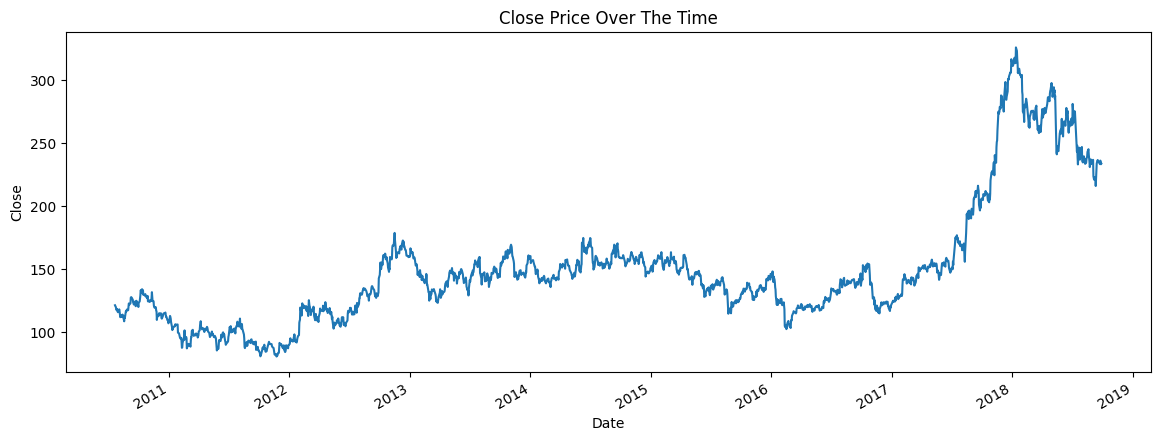

In [5]:
plt.figure(figsize=(14,5))
df['Close'].plot(x=df.index)
plt.ylabel('Close')
plt.title('Close Price Over The Time')
plt.show()

In [6]:
data = df[['Close']]
data = data.sort_index()
data

,Close
Date,
2010-07-21,121.55
2010-07-22,120.90
2010-07-23,120.65
2010-07-26,117.60
2010-07-27,118.65
...,...
2018-09-24,233.30
2018-09-25,236.10
2018-09-26,234.25


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.62622549],
       [0.62214052],
       [0.62418301]])

In [8]:
scaled_data.shape

(2035, 1)

In [9]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
train_data.shape,test_data.shape

((1628, 1), (407, 1))

In [10]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [11]:
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [12]:
X_test.shape,X_train.shape

((397, 10, 1), (1618, 10, 1))

In [13]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[RootMeanSquaredError()])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
h = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
26/26 [==============================] - 3s 23ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.1180 - val_root_mean_squared_error: 0.3434
Epoch 2/100
26/26 [==============================] - 0s 11ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238
Epoch 3/100
26/26 [==============================] - 0s 11ms/step - loss: 9.8922e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 4/100
26/26 [==============================] - 0s 11ms/step - loss: 6.3330e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 5/100
26/26 [==============================] - 0s 11ms/step - loss: 6.0238e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 5.9302e-04 - root_mean_squared_error: 0.0244 - val_los

In [16]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

13/13 [==============================] - 0s 2ms/step


In [17]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [18]:
result = pd.DataFrame({
    "Metrics":["Mean Squared Error","Mean Absolute Error"],
    "Training Result":[mean_squared_error(y_train,train_pred),mean_absolute_error(y_train,train_pred)],
    "Testing Result":[mean_squared_error(y_test,test_pred),mean_absolute_error(y_test,test_pred)]
})
result.style.background_gradient(cmap='BuPu')

,Metrics,Training Result,Testing Result
0,Mean Squared Error,17994.614075,50967.529477
1,Mean Absolute Error,132.349912,220.202418


<function matplotlib.pyplot.show(close=None, block=None)>

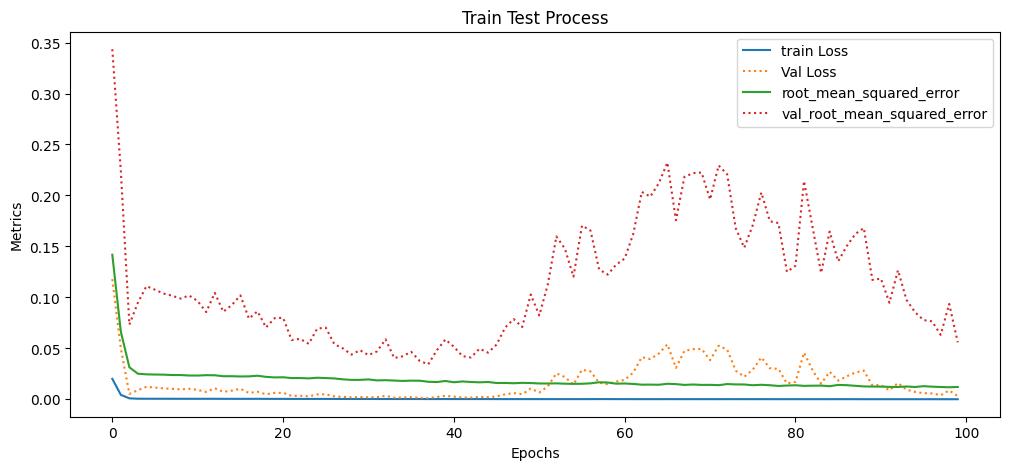

In [19]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(100),h.history['loss'],label="train Loss")
plt.plot(np.arange(100),h.history['val_loss'],ls=":",label="Val Loss")
plt.plot(np.arange(100),h.history['root_mean_squared_error'],label="root_mean_squared_error")
plt.plot(np.arange(100),h.history['val_root_mean_squared_error'],ls=":",label="val_root_mean_squared_error")
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Train Test Process')
plt.legend()
plt.show

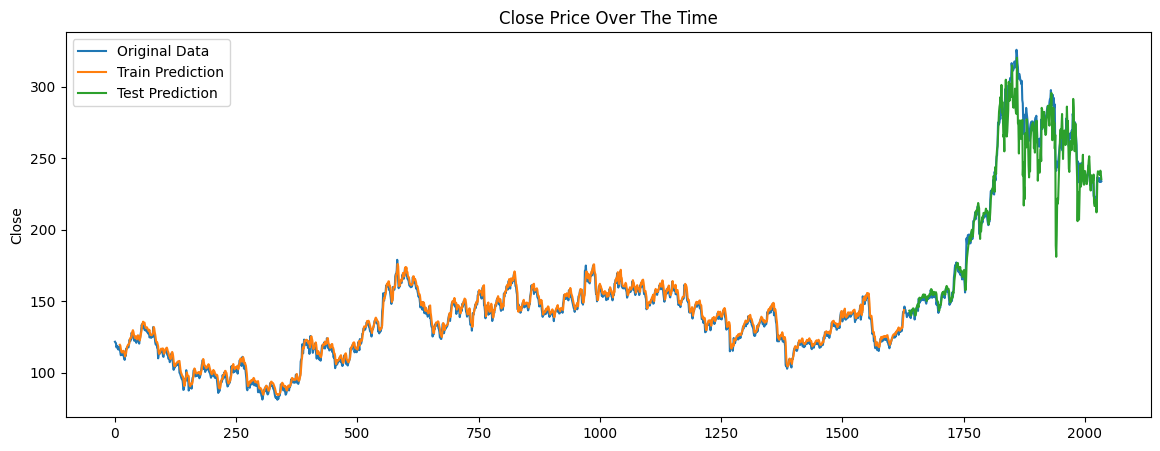

In [20]:
look_back = sequence_length
train_pred_plot = np.empty_like(data)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back,:] = train_pred

test_pred_plot = np.empty_like(data)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+(look_back*2):len(df),:] = test_pred

plt.figure(figsize=(14,5))
plt.plot(scaler.inverse_transform(scaled_data),label="Original Data")
plt.plot(train_pred_plot,label="Train Prediction")
plt.plot(test_pred_plot,label="Test Prediction")
plt.ylabel('Close')
plt.title('Close Price Over The Time')
plt.legend()
plt.show()


In [21]:
x_input = test_data[test_data.shape[0]-sequence_length:].reshape(1,-1)
x_input.shape

(1, 10)

In [22]:
temp_input = list(x_input)
temp_input

[array([0.625     , 0.63582516, 0.62949346, 0.62888072, 0.62765523,
        0.62234477, 0.63378268, 0.62622549, 0.62214052, 0.62418301])]

In [23]:
temp_input = temp_input[0].tolist()
temp_input

[0.625,
 0.6358251633986928,
 0.6294934640522877,
 0.6288807189542484,
 0.6276552287581699,
 0.6223447712418301,
 0.6337826797385621,
 0.6262254901960784,
 0.622140522875817,
 0.6241830065359477]

In [24]:
lst_output = []
n_steps = sequence_length
i = 0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

lst_output

[0.62969035]
11
[0.62969035]
12
[0.62969035]
13
[0.62969035]
14
[0.62969035]
15
[0.62969035]
16
[0.62969035]
17
[0.62969035]
18
[0.62969035]
19
[0.62969035]
20
[0.62969035]
21
[0.62969035]
22
[0.62969035]
23
[0.62969035]
24
[0.62969035]
25
[0.62969035]
26
[0.62969035]
27
[0.62969035]
28
[0.62969035]
29
[0.62969035]
30
[0.62969035]
31
[0.62969035]
32
[0.62969035]
33
[0.62969035]
34
[0.62969035]
35
[0.62969035]
36
[0.62969035]
37
[0.62969035]
38
[0.62969035]
39
[0.62969035]
40


[[0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203],
 [0.6296903491020203]]